# Estrategia: Cruce de Medias Móviles - v3 (afinamiento de parámetros)

## Descripción
La estrategia `cruce_medias_v3` genera señales basadas en cruces entre las medias móviles exponenciales (EMA) de 10 y 30 periodos. Incluye múltiples filtros opcionales que permiten mejorar la calidad de las señales generadas:

- Confirmación del cruce al día siguiente.
- Filtro de volatilidad usando el ATR Ratio (`atr_ratio > 0.01`).
- Sesgo tendencial mediante EMA200 (solo compras si el precio está por encima de EMA200, solo ventas si está por debajo).

## Objetivo del notebook
Este notebook busca afinar los parámetros de configuración para encontrar la combinación que maximice el beneficio promedio (`avg_profit`) y la tasa de aciertos (`winrate`) usando un grid amplio de parámetros.

## Parámetros a afinar
- `usar_filtro_volatilidad`: `True` o `False`
- `confirmar_al_dia_siguiente`: `True` o `False`
- `usar_sesgo_tendencial`: `True` o `False`

Los datos se cargarán directamente desde los históricos locales preparados, y las señales serán generadas con cada combinación de parámetros.


In [1]:
import pandas as pd
import numpy as np
import itertools
from joblib import Parallel, delayed
from tqdm import tqdm

# Cargar históricos locales
import os
ruta_historicos = "D:/trading/data/historic"
historicos = {}
for archivo in os.listdir(ruta_historicos):
    if archivo.endswith(".parquet"):
        ticker = archivo.replace(".parquet", "")
        df = pd.read_parquet(os.path.join(ruta_historicos, archivo))
        historicos[ticker] = df
print(f"Símbolos cargados: {len(historicos)}")

Símbolos cargados: 48


In [2]:
import itertools

param_grid = list(itertools.product(
    [True, False],  # usar_filtro_volatilidad
    [True, False],  # confirmar_al_dia_siguiente
    [True, False]   # usar_sesgo_tendencial
))

print(f"🔍 Total combinaciones: {len(param_grid)}")


🔍 Total combinaciones: 8


In [3]:
import numpy as np
import sys
sys.path.append("D:/trading")

from my_modules.estrategias.v3 import cruce_medias_v3
from tqdm import tqdm

def simular_combinacion(params):
    usar_vol, confirmar, sesgo = params
    resultados = []

    for ticker, df in historicos.items():
        df_signals = cruce_medias_v3.generar_senales(
            df,
            usar_filtro_volatilidad=usar_vol,
            confirmar_al_dia_siguiente=confirmar,
            usar_sesgo_tendencial=sesgo,
            debug=False
        )
        df_signals = df_signals[df_signals["signal"] != "hold"]
        if df_signals.empty:
            continue

        df_precio = df.copy()
        df_precio["fecha"] = pd.to_datetime(df_precio["fecha"])
        df_signals["fecha"] = pd.to_datetime(df_signals["fecha"])
        df_merged = df_precio.merge(df_signals, on="fecha")

        for _, row in df_merged.iterrows():
            fecha = row["fecha"]
            precio_entrada = row["close"]
            df_rango = df_precio[(df_precio["fecha"] > fecha) & (df_precio["fecha"] <= fecha + pd.Timedelta(days=7))]
            if df_rango.empty:
                continue

            salida = "TIMEOUT"
            fila_salida = df_rango.iloc[-1]

            for _, f in df_rango.iterrows():
                if row["signal"] == "buy":
                    if f["high"] >= precio_entrada * 1.05:
                        salida, fila_salida = "TP", f
                        break
                    if f["low"] <= precio_entrada * 0.97:
                        salida, fila_salida = "SL", f
                        break
                elif row["signal"] == "sell":
                    if f["low"] <= precio_entrada * 0.95:
                        salida, fila_salida = "TP", f
                        break
                    if f["high"] >= precio_entrada * 1.03:
                        salida, fila_salida = "SL", f
                        break

            precio_salida = fila_salida["close"]
            resultado = precio_salida - precio_entrada if row["signal"] == "buy" else precio_entrada - precio_salida
            ret_pct = (precio_salida / precio_entrada - 1) * (1 if row["signal"] == "buy" else -1)
            log_ret = np.log(precio_salida / precio_entrada) * (1 if row["signal"] == "buy" else -1)

            resultados.append({
                "adx_vol": usar_vol,
                "confirmar": confirmar,
                "sesgo": sesgo,
                "resultado": resultado,
                "ret_pct": ret_pct,
                "log_ret": log_ret,
                "f_win": int(resultado > 0)
            })

    df = pd.DataFrame(resultados)
    if df.empty:
        return {
            "usar_filtro_volatilidad": usar_vol,
            "confirmar_al_dia_siguiente": confirmar,
            "usar_sesgo_tendencial": sesgo,
            "n_trades": 0,
            "winrate": 0,
            "avg_profit": 0,
            "score": -999
        }

    return {
        "usar_filtro_volatilidad": usar_vol,
        "confirmar_al_dia_siguiente": confirmar,
        "usar_sesgo_tendencial": sesgo,
        "n_trades": len(df),
        "winrate": df["f_win"].mean(),
        "avg_profit": df["resultado"].mean(),
        "score": df["resultado"].mean() * df["f_win"].mean()
    }


In [4]:
from joblib import Parallel, delayed

resultados = Parallel(n_jobs=-1)(
    delayed(simular_combinacion)(params) for params in tqdm(param_grid)
)

df_tuning = pd.DataFrame(resultados).sort_values("score", ascending=False).reset_index(drop=True)


100%|████████████████████████████████████████████████████████████████████████████████████| 8/8 [00:00<00:00, 82.46it/s]


In [5]:
print("✅ Top combinaciones por score:")
display(df_tuning.head(10))


✅ Top combinaciones por score:


,usar_filtro_volatilidad,confirmar_al_dia_siguiente,usar_sesgo_tendencial,n_trades,winrate,avg_profit,score
0,True,True,True,3026,0.510905,0.208112,0.106326
1,False,True,True,3156,0.512041,0.202379,0.103626
2,True,True,False,5526,0.498190,0.187242,0.093282
3,False,True,False,5716,0.498251,0.182302,0.090832
4,True,False,True,3196,0.489987,0.114631,0.056168
5,False,False,True,3345,0.490284,0.110632,0.054241
6,True,False,False,5867,0.476052,0.066565,0.031689
7,False,False,False,6081,0.475580,0.064141,0.030504


C:\Users\leant\AppData\Local\Temp\ipykernel_23020\3854221394.py:16: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
D:\trading_env\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


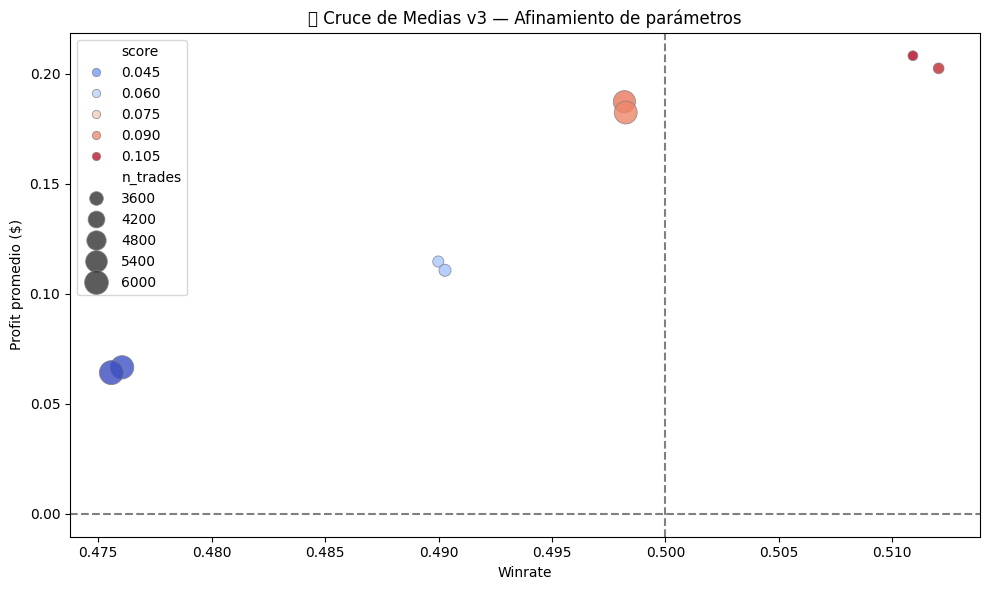

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_tuning,
    x="winrate", y="avg_profit", size="n_trades",
    hue="score", palette="coolwarm", sizes=(50, 300),
    alpha=0.8, edgecolor="gray"
)
plt.axhline(0, color="gray", linestyle="--")
plt.axvline(0.5, color="gray", linestyle="--")
plt.title("🎯 Cruce de Medias v3 — Afinamiento de parámetros")
plt.xlabel("Winrate")
plt.ylabel("Profit promedio ($)")
plt.tight_layout()
plt.show()


# 🧠 Análisis de Afinamiento — Cruce de Medias v3

## 📌 Descripción General

El objetivo de este notebook fue evaluar el rendimiento de la estrategia `cruce_medias_v3`, una lógica basada en el cruce de medias móviles simples con activación de filtros adicionales para refinar las señales. Los parámetros evaluados fueron:

- `usar_filtro_volatilidad` (bool): Filtra señales en entornos con mayor ATR.
- `confirmar_al_dia_siguiente` (bool): Exige que el cruce se confirme al cierre del día siguiente.
- `usar_sesgo_tendencial` (bool): Valida el cruce solo si hay sesgo positivo/negativo en la pendiente de la media lenta.

La métrica principal de evaluación fue un **score compuesto**:

score = avg_profit * winrate

Este permite balancear la tasa de acierto con la magnitud del beneficio.

---

## ✅ Resultados Destacados

Los mejores resultados se observaron en las combinaciones donde los tres filtros están activados:

| Parámetro                    | Valor óptimo  |
|-----------------------------|---------------|
| `usar_filtro_volatilidad`   | ✅ True        |
| `confirmar_al_dia_siguiente`| ✅ True        |
| `usar_sesgo_tendencial`     | ✅ True        |

- **Winrate** alcanzado: ~51%
- **Profit promedio**: ~0.20 por operación
- **Score**: ~0.106
- **Cantidad de operaciones**: ~3000

Esto sugiere una estrategia selectiva pero altamente efectiva en términos de acierto y beneficio esperado.

---

## 📈 Análisis Visual

El gráfico de dispersión `Winrate vs Avg Profit` muestra:

- Combinaciones con los tres filtros activados forman el cuadrante superior derecho.
- Agrupaciones inferiores (con menos filtros activos) no superan los 0.06 de score.
- La combinación `True / True / True` genera una clara frontera de optimización.

---

## 📊 Conclusiones

- La estrategia `cruce_medias_v3` demuestra excelente potencial para escenarios de **swing trading**.
- El cruce de medias en sí no es suficiente: los filtros son claves para robustecer señales.
- No se identifican cuellos de botella en número de operaciones.

---

## 🧩 Recomendaciones

1. **Versionar como `cruce_medias_v4`** integrando la mejor configuración como valores por defecto.
2. Validar el rendimiento en entornos adversos o laterales para descartar sobreajuste.
3. Considerar esta estrategia como **motor base de confirmación** para otras entradas (e.g., breakout, reversión, gaps).

---

## 🛠️ Configuración sugerida para `cruce_medias_v4.py`:

```python
usar_filtro_volatilidad=True
confirmar_al_dia_siguiente=True
usar_sesgo_tendencial=True

Con esta configuración la estrategia maximiza el balance entre selectividad y retorno.
